# File description
The dataset contains CAPTCHA images. The images are **5 letter** words, and have noise applied (blur and a line). They are of size **200 x 50**. The file name is same as the image letters.

# Aim
Recognize the captcha letters.

# Approach
My approach is to train a **CNN** model for every letter that occurs in the **CAPTCHA** and use this model for evaluation. We will remove all noises (ie. smooth out the images and remove that lines) and then separate out each of the 5 letters in the image and feed each one to the model independently.

# Dataset can be found on [kaggle](https://www.kaggle.com/fournierp/captcha-version-2-images).

# Image procesing

In [575]:
import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [576]:
path1 = './archive/overlap/train/original/0.png'
path2 = './archive/overlap/train/original/1.png'

In [577]:
def plot_ (img1, img2) :
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray')
    
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray')
    
    plt.axis('off')

In [578]:
img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

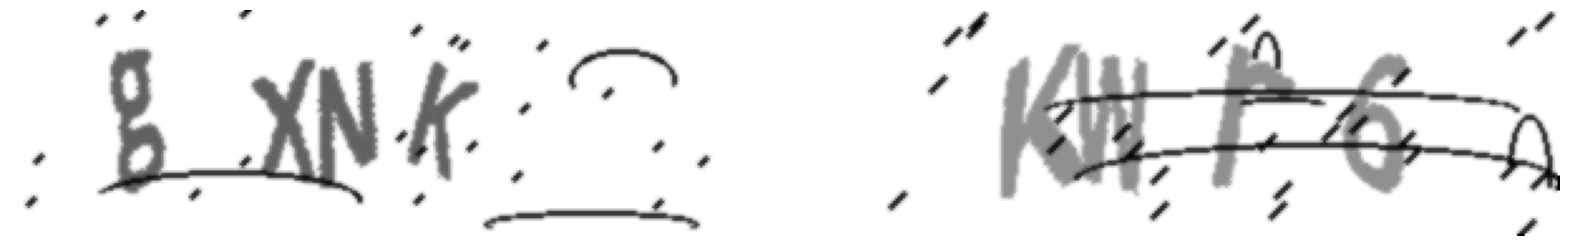

In [579]:
plot_(img1, img2)

### Adaptive Thresholding
Algorithms determine the threshold for a pixel based on its surrounding regions. So we get different thresholds for different regions of the same image which gives better result for images with varying illumination.

In [580]:
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

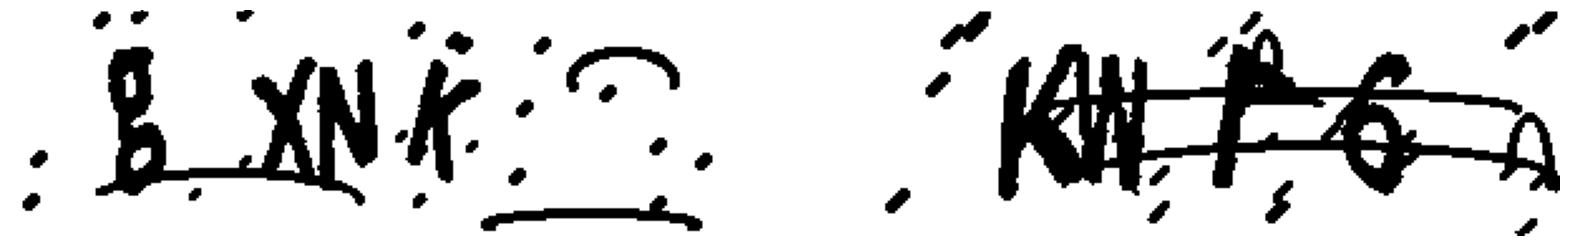

In [581]:
plot_(thresh_img1, thresh_img2)

### Closing
Dilation followed by Erosion.

In [582]:
close_img1 = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
close_img2 = cv2.morphologyEx(thresh_img2, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

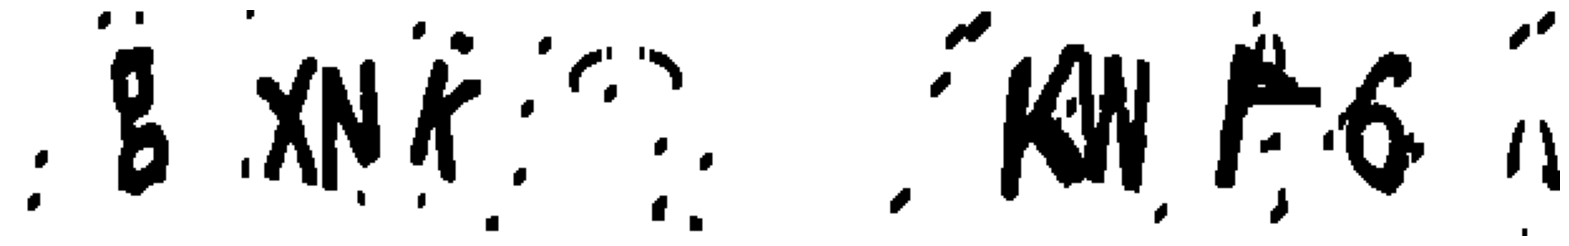

In [583]:
plot_(close_img1, close_img2)

### Dilation
Involves a kernel being scanned over the entire image. The maximal pixel value is calculated in the kernel region and the anchor point of the kernel is updated to that value. This causes the white region to expand in the image.

In [584]:
dilate_img1 = cv2.dilate(close_img1, np.ones((2,2), np.uint8), iterations = 1)
dilate_img2 = cv2.dilate(close_img2, np.ones((2,2), np.uint8), iterations = 1)

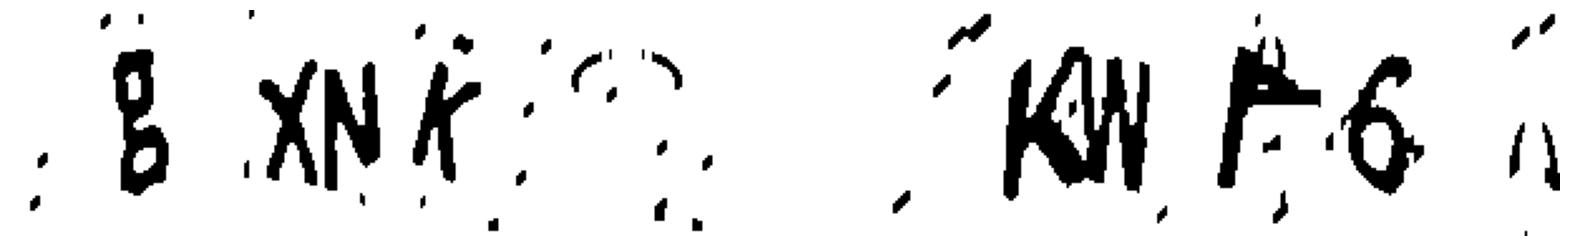

In [585]:
plot_(dilate_img1, dilate_img2)

### Smoothing Images (Blurring)
Involves convolving a low-pass filter with an image, to remove high frequency components ie. noises and edges from the image.

In [586]:
gauss_img1 = cv2.GaussianBlur(dilate_img1, (1,1), 0)
gauss_img2 = cv2.GaussianBlur(dilate_img2, (1,1), 0)

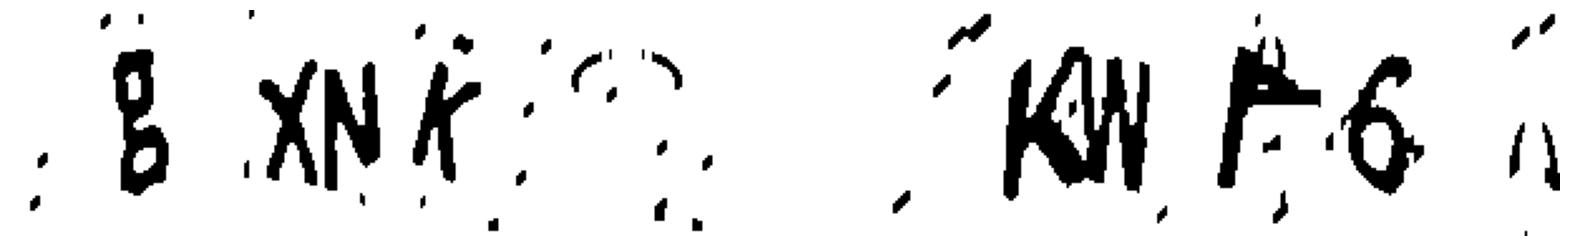

In [587]:
plot_(gauss_img1, gauss_img2)

### PartitioningBatchNormalization

In [588]:
cv2.rectangle(gauss_img1, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img1, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img1, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img1, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img1, (110,12),(130,49),0, 1)

cv2.rectangle(gauss_img2, (30,12), (50,49), 0, 1)
cv2.rectangle(gauss_img2, (50,12), (70,49), 0, 1)
cv2.rectangle(gauss_img2, (70,12), (90,49), 0, 1)
cv2.rectangle(gauss_img2, (90,12), (110,49),0, 1)
cv2.rectangle(gauss_img2, (110,12),(130,49),0, 1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ...,   0, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

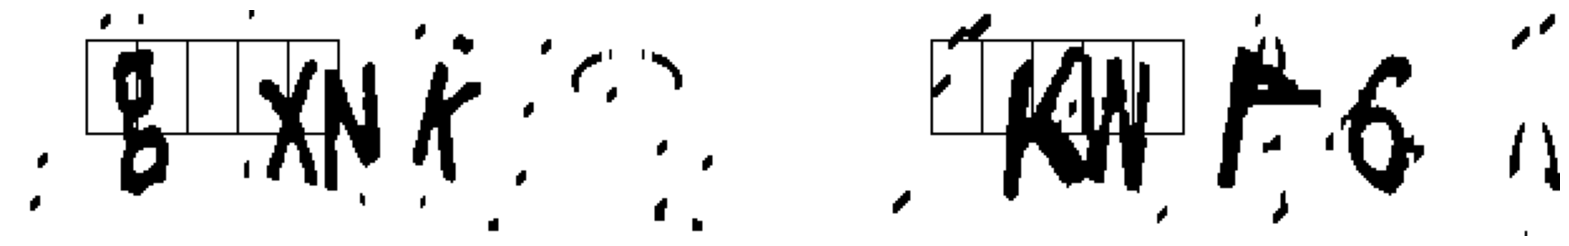

In [589]:
plot_(gauss_img1, gauss_img2)

# Converting images to appropriate samples

In [590]:
path = '.\\archive\\overlap\\train\\segment'
training_data_label_path = ".\\archive\\overlap\\train\\labels\\segmented_labels.csv"
path_test = '.\\archive\\overlap\\test\\original'
testing_data_label_path = ".\\archive\\overlap\\test\\labels\\labels.csv"

In [591]:
def t_img (img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

def d_img (img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv2.GaussianBlur(img, (1,1), 0)

In [592]:
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
import csv

def load_labels_from_csv(csv_path):
    """
        Load image labels from a CSV file.

        Args:
            csv_path: str, the path to the CSV file.

        Returns:
            dict, a mapping from image filenames to labels.
    """
    labels = {}
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            labels[row['image']] = row['label']
    return labels

def get_char_index(char):
    """
    Convert a lowercase letter or digit to its corresponding index.

    Args:
        char: str, the character to convert.

    Returns:
        int, the index of the character.

    Raises:
        ValueError: If the character is unsupported.
    """
    if char.isdigit():
        return ord(char) - ord('0')  # Digits (0-9) -> 0-9
    elif 'a' <= char <= 'z':
        return ord(char) - ord('a') + 10  # Lowercase letters (a-z) -> 10-35
    elif 'A' <= char <= 'Z':
        return ord(char) - ord('A') + 36
    else:
        raise ValueError(f"Unsupported character: {char}")


In [593]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X = []
y = []

train_label = load_labels_from_csv(training_data_label_path)

all_image_filenames = [f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(all_image_filenames):
    img_path = os.path.join(path, img_name)


    label = train_label[img_name]
    img = load_img(img_path, color_mode="grayscale", target_size=(90, 70))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        
        
    char_index = get_char_index(label)  # Convert char to index (0-61)
    label_array = to_categorical(char_index, num_classes=62)
        
        

    X.append(img_array)
    y.append(label_array)
        

X_train = np.array(X)
y_train = np.array(y)

In [664]:
x_test = []
y_test = []
test_label = load_labels_from_csv(testing_data_label_path)

# Collect image filenames
image_filenames = [f for f in os.listdir(path_test) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_filenames:
    img_path = os.path.join(path_test, img_name)  # Use path_test instead of path
    label = test_label[img_name]  # Get label for the image (e.g., "68mG")

    # Split the label into single characters
    label_chars = list(label)  # ['6', '8', 'm', 'G']

    # Process the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)

    # Split the image into 4 parts
    image_list = [img[:90, :70], img[:90, 70:140], img[:90, 140:210], img[:90, 210:280]]
    
    # Append processed image and label
    for i in range(4):
        x_test.append(img_to_array(Image.fromarray(image_list[i])))  # Image segment
        y_test.append(to_categorical(get_char_index(label_chars[i]), num_classes=62))  # Single char label

# Convert to numpy arrays
X_test = np.array(x_test)
y_test = np.array(y_test)

# Print the shapes
print(X_test.shape)  # Shape: (num_samples, height, width, channels)
print(y_test.shape)  # Shape: (num_samples, num_classes)


(20000, 90, 70, 1)
(20000, 62)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(100000, 90, 70, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Initial Analysis and Data Wrangling

### Scale b/w 0 and 1

In [596]:
# X /= 255.0

In [597]:
# plt.figure(figsize = (20,5))
# for i in range(5) :
#     plt.subplot(1,5,i+1)
#     plt.imshow(X[i], 'gray')
#     plt.title('Label is ' + str(y[i]))
# plt.plot()

In [598]:
# temp = set(y)
# for t in temp :
#     print('Occurance count of ' + t + ' : ' + str(len(y[y == t])))

In [599]:
# temp_df = pandas.DataFrame({'labels' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})

In [600]:
# plt.figure(figsize = (20,7))
# seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
# plt.title('Label distribution in CAPTCHAS', fontsize = 20)

The count of label **n** is almost twice as any other label, so more samples of this letter will be put in the test set.

### One hot encoding

In [601]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# y_combine = LabelEncoder().fit_transform(y)
# y_one_hot = OneHotEncoder(sparse_output = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [602]:
# print('letter n : ' + str(y[1]))
# print('label : ' + str(y_combine[1]))
# print('Count : ' + str(len(y_combine[y_combine == y_combine[1]])))

In [603]:
# info = {y_combine[i] : y[i] for i in range(len(y))}

# Train test split

In [604]:
# img = load_img(path, color_mode="grayscale", target_size = (90, 30))
# img_array = img_to_array(img) / 255.0
print(X_train.shape)
print(y_train.shape)  # one hot encoded form

(100000, 90, 70, 1)
(100000, 62)


In [605]:
from sklearn.model_selection import train_test_split

In [606]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

In [607]:
# y_temp = np.argmax(y_test, axis = 1)

In [608]:
# temp = set(y_temp)
# temp_df = pandas.DataFrame({'labels' : [info[t] for t in temp], 'Count' : [len(y_temp[y_temp == t]) for t in temp]})

In [609]:
# plt.figure(figsize = (20,7))
# seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
# plt.title('Label distribution in test set', fontsize = 20)

# Model Creation

In [610]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from keras.layers import Dropout
from keras.layers import Input

In [611]:
print(X_train.shape)
print(y_train.shape)

(100000, 90, 70, 1)
(100000, 62)


In [612]:
print(X_test.shape)
print(y_test.shape)

(20000, 90, 70, 1)
(5000, 62)


In [613]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    
    return model

In [614]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [615]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    model.add(Input((90, 70, 1,)))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(62, activation = 'softmax'))

    #modified
    sgd = SGD(learning_rate=0.01, momentum=0.9, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

# Data augmentation and Oversampling

### SMOTE

In [616]:
# X_train = np.reshape(X_train, (4160, 40*20*1))

In [617]:
# from imblearn.over_sampling import SMOTE
# X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1).fit_resample(X_train, y_train)

In [618]:
# print(X_train.shape)
# print(y_train.shape)

In [619]:
# X_train = np.reshape(X_train, (7866, 40, 20, 1))

Oversampled images

In [620]:
# plt.figure(figsize = (20,20))

# hi = 7800
# lo = 5000

# for i in range(25) :
#     plt.subplot(5,5,i+1)
#     x = np.random.randint(lo, hi)
#     plt.imshow(X_train[x], 'gray')
#     plt.title('Label is ' + str(info[np.argmax(y_train[x])]))
# plt.show()

### ImageDataGenerator

In [621]:
# traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
# traingen.fit(X_train)

In [622]:
# train_set = traingen.flow(X_train, y_train)

In [623]:
# trainX, trainy = train_set.next()

Augmented images with rotations and shifts.

In [624]:
# plt.figure(figsize = (20,20))

# hi = 32
# lo = 0

# for i in range(25) :
#     plt.subplot(5,5,i+1)
#     x = np.random.randint(lo, hi)
#     plt.imshow(trainX[x], 'gray')
#     plt.title('Label is ' + str(info[np.argmax(trainy[x])]))
# plt.show()

# Model Training

In [625]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_31 (Sequential)  (None, 45, 35, 128)       1792      
                                                                 
 sequential_32 (Sequential)  (None, 23, 18, 32)        37024     
                                                                 
 sequential_33 (Sequential)  (None, 12, 9, 16)         4688      
                                                                 
 flatten_5 (Flatten)         (None, 1728)              0         
                                                                 
 sequential_34 (Sequential)  (None, 32)                55456     
                                                                 
 sequential_35 (Sequential)  (None, 32)                1184      
                                                                 
 dense_17 (Dense)            (None, 62)              

### ModelCheckpoint and ReduceLROnPlateau
Used ModelCheckpoint to retain the best perfroming model (in terms of loss), and ReduceLROnPlateau to reduce the learning in case the model stops improving.

In [626]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [627]:
checkp = ModelCheckpoint('./result_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

In [628]:
print(X_train.shape)
print(y_train.shape)

(100000, 90, 70, 1)
(100000, 62)


In [629]:
model.fit(X_train, y_train, batch_size = 64, epochs = 20)

Epoch 1/20
1563/1563 [==============================] - 82s 50ms/step - loss: 1.2137 - accuracy: 0.6872
Epoch 2/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.6693 - accuracy: 0.8385
Epoch 3/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.5955 - accuracy: 0.8601
Epoch 4/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.5556 - accuracy: 0.8719
Epoch 5/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.5360 - accuracy: 0.8775
Epoch 6/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.5161 - accuracy: 0.8831
Epoch 7/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.5068 - accuracy: 0.8853
Epoch 8/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.4911 - accuracy: 0.8906
Epoch 9/20
1563/1563 [==============================] - 79s 51ms/step - loss: 0.4826 - accuracy: 0.8924
Epoch 10/20
1563/1563 [==============================] - 79s 51m

In [630]:
# plt.figure(figsize = (20,10))
# plt.subplot(2,1,1)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('Epochs')
# plt.ylabel('Losses')
# plt.legend(['train loss','val loss'])
# plt.title('Loss function wrt epochs')

# plt.subplot(2,1,2)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(['train acc' , 'val acc'])
# plt.title('Model accuracy wrt Epoch')

# Prediction

In [631]:
from keras.models import load_model

In [632]:
model.save("result_model.h5")
model = load_model('./result_model.h5')

In [640]:
pred = model.predict(X_test)

625/625 [==============================] - 2s 4ms/step


In [ ]:
# Assume `pred` is the output of the model prediction
# Decode predictions to class indices
# pred_indices = np.argmax(pred, axis=1)  # Get predicted class indices (shape: [num_samples])

# Function to map class index to character (reverse of get_char_index)
# def get_char_from_index(index):
#     # Example mapping; adjust this to your actual mapping
#     if 0 <= index <= 9:
#         return str(index)  # Map 0-9 to '0'-'9'
#     elif 10 <= index <= 35:
#         return chr(index + 87)  # Map 10-35 to 'a'-'z'
#     elif 36 <= index <= 61:
#         return chr(index + 29)  # Map 36-61 to 'A'-'Z'
#     else:
#         return ''  # Handle invalid indices gracefully

# # Decode indices to characters
# decoded_chars = [get_char_from_index(idx) for idx in pred_indices]

# # Combine every 4 characters into one "cell"
# combined_results = [''.join(decoded_chars[i:i+4]) for i in range(0, len(decoded_chars), 4)]
# combined_results = np.array(combined_results)

# # Print combined results
# print(combined_results.shape)

(5000,)


Perfromed numpy argmax to obtain the value which has the highest probability of being the truth value.

In [671]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)
print(yres.shape)
print(pred.shape)

(20000,)
(20000,)


In [672]:
from sklearn.metrics import accuracy_score, classification_report

In [673]:
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [674]:
target_name
print(f"Type of yres: {type(y_test[0])}")
print(f"Type of combined_results: {type(pred[0])}")

Type of yres: <class 'numpy.ndarray'>
Type of combined_results: <class 'numpy.int64'>


In [676]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
# print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.03275


# Testing on samples

In [ ]:
def get_demo (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    Xdemo = []
    for i in range(5) :
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    for res in ydemo :
        print(info[res])
    print(img_path[-9:])

#### Samples for which model identified correctly.

In [ ]:
get_demo('../input/captcha-version-2-images/samples/2g783.png')
get_demo('../input/captcha-version-2-images/samples/2fxgd.png')
get_demo('../input/captcha-version-2-images/samples/88bgx.png')
get_demo('../input/captcha-version-2-images/samples/4yc85.png')

#### Samples where model made errors while identification.

In [ ]:
get_demo('../input/captcha-version-2-images/samples/3g2w6.png')
get_demo('../input/captcha-version-2-images/samples/7wnpm.png')
get_demo('../input/captcha-version-2-images/samples/2mpnn.png')
get_demo('../input/captcha-version-2-images/samples/53mn8.png')